In [1]:
import torch

## **Empty Torch Cache and Check cuda is available**

In [2]:

print("cuda Available:", torch.cuda.is_available())
torch.cuda.empty_cache()

cuda Available: False


## **Importing essentials**

In [3]:
try:
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    from torch.utils.data import DataLoader
    from torchvision import transforms
    from torchvision.datasets import ImageFolder
    print("All libraries imported successfully.")
except ImportError as e:
    print(f"Error importing libraries: {e} please install packages using pip install -r requirements.txt")

All libraries imported successfully.


## **Load Dataset and Transform Dataset**

```
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
]) 

Converts 1:1 ratio picture -> ( 128 x 128 ) pixels


```
train_dataset.classes contains all the subfolder names of data/train

In [4]:
# loading datasets 


data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = ImageFolder(root='data/train', transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,)
test_dataset = ImageFolder(root='data/validation', transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,)

exp_classes = train_dataset.classes


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Classes: {exp_classes}")

Number of training samples: 28821
Number of testing samples: 7066
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## **Building Model**




In [5]:
class FaceClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## **Using Model**

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceClassifier(len(exp_classes)).to(device)

## **Oprimizers and Criterion**

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## **Model Training**

In [8]:
n_epochs = 20 
losses = []
for epoch in range(n_epochs):  
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    if (epoch+1) % 5 == 0:
        epoch_loss = running_loss / len(train_dataset)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")

Epoch 5/20, Loss: 0.6212
Epoch 10/20, Loss: 0.1832
Epoch 15/20, Loss: 0.1245
Epoch 20/20, Loss: 0.1013


In [14]:
X = [i*5 for i in range(1,len(losses)+1)]
X,losses

([5, 10, 15, 20],
 [0.6211655946750064,
  0.18324419946757559,
  0.12451788764563951,
  0.10125209465865903])

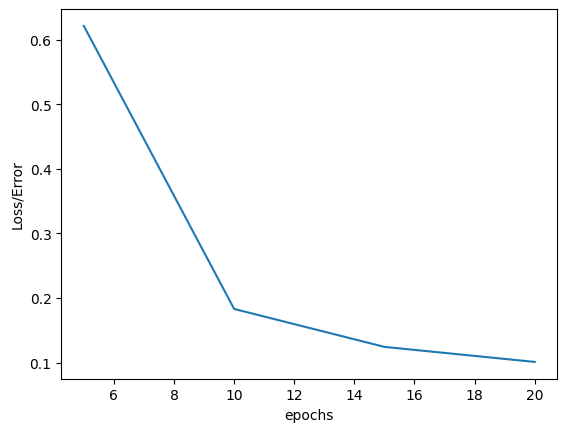

In [15]:
import matplotlib.pyplot as plt

plt.plot(X, losses)
plt.xlabel("epochs")
plt.ylabel("Loss/Error")
plt.show()


## **Save model**

In [16]:
torch.save(model.state_dict(), 'face_classifier.pth')

import pickle

with open('classes.pkl', 'wb') as f:
    pickle.dump(exp_classes, f)
print("Model and classes saved successfully.")

Model and classes saved successfully.


## **Load and Test**

In [17]:
# load model for testing
exp_classes = pickle.load(open('classes.pkl', 'rb'))

model = FaceClassifier(len(exp_classes)).to(device)

model.load_state_dict(torch.load('face_classifier.pth'))
model.eval()

FaceClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [19]:
print("Evaluating torch loaded model on test data...")

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Test Accuracy: {100 * correct / total:.2f}%")


Evaluating torch loaded model on test data...
Test Accuracy: 54.44%
